In [49]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np


In [50]:
import plotly.express as px

In [51]:
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score

In [52]:
# аналогичным образом загружаем данные о пассажирах
df = pd.read_csv('data/Dutch weekly survey on leftright political orientation 19781996.csv')
# неподходящий формат данных приводим к тому, с которым Pandas может работать
# также устанавливаем индекс и сортируем
df = df.set_index('time').sort_index()
df = pd.DataFrame(df['Cda'])

In [53]:
df

,Cda
time,
1,4.9643
2,4.9923
3,5.0844
4,5.2417
5,5.0712
...,...
984,4.4088
985,4.5083
986,4.3652


## Предсказание временного ряда с помощью деревьев

Попробуем обычное дерево решений и случайный лес, а потом сравним результаты

In [54]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from numpy import asarray

In [55]:
n_vars = 1 if type(df) is list else df.shape[1]
cols = list()
for i in range(1, 0, -1):
    cols.append(df.shift(i))
for i in range(0, 1):
    cols.append(df.shift(-i))
# put it all together
agg = pd.concat(cols, axis=1)
agg.dropna(inplace=True)
list_for_forecast = agg.values

In [56]:
len(list_for_forecast)

987

In [57]:
def decision_tree_forecast(train, testX):
    train = asarray(train)
    trainX, trainy = train[:, :-1], train[:, -1]
    model = DecisionTreeRegressor(random_state=0)
    model.fit(trainX, trainy)
    yhat = model.predict([testX])
    return yhat[0]

In [58]:
def random_forest_forecast(train, testX):
    train = asarray(train)
    trainX, trainy = train[:, :-1], train[:, -1]
    model = RandomForestRegressor(n_estimators=1000)
    model.fit(trainX, trainy)
    yhat = model.predict([testX])
    return yhat[0]

In [59]:
predictions = list()
size = int(len(list_for_forecast) * 0.66)
train, test = list_for_forecast[0:size], list_for_forecast[size:len(list_for_forecast)]
history = [x for x in train]

for i in range(len(test)):
    testX, testy = test[i, :-1], test[i, -1]
    yhat = random_forest_forecast(history, testX)
    predictions.append(yhat)
    history.append(test[i])

error = mean_absolute_error(test[:, -1], predictions)
print("Random Forest error: ", error)

Random Forest error:  0.09945732281768947


In [60]:
print("Random Forest metrics: ")
print("RMSE:", np.sqrt(mean_squared_error(test[:, -1], predictions)))
print("MAPE:", mean_absolute_percentage_error(test[:, -1], predictions))
print("MAE:", mean_absolute_error(test[:, -1], predictions))
print("R2: ", r2_score(test[:, -1], predictions))

Random Forest metrics: 
RMSE: 0.1255262381139746
MAPE: 0.022181636767726685
MAE: 0.09945732281768947
R2:  0.1277474131976314


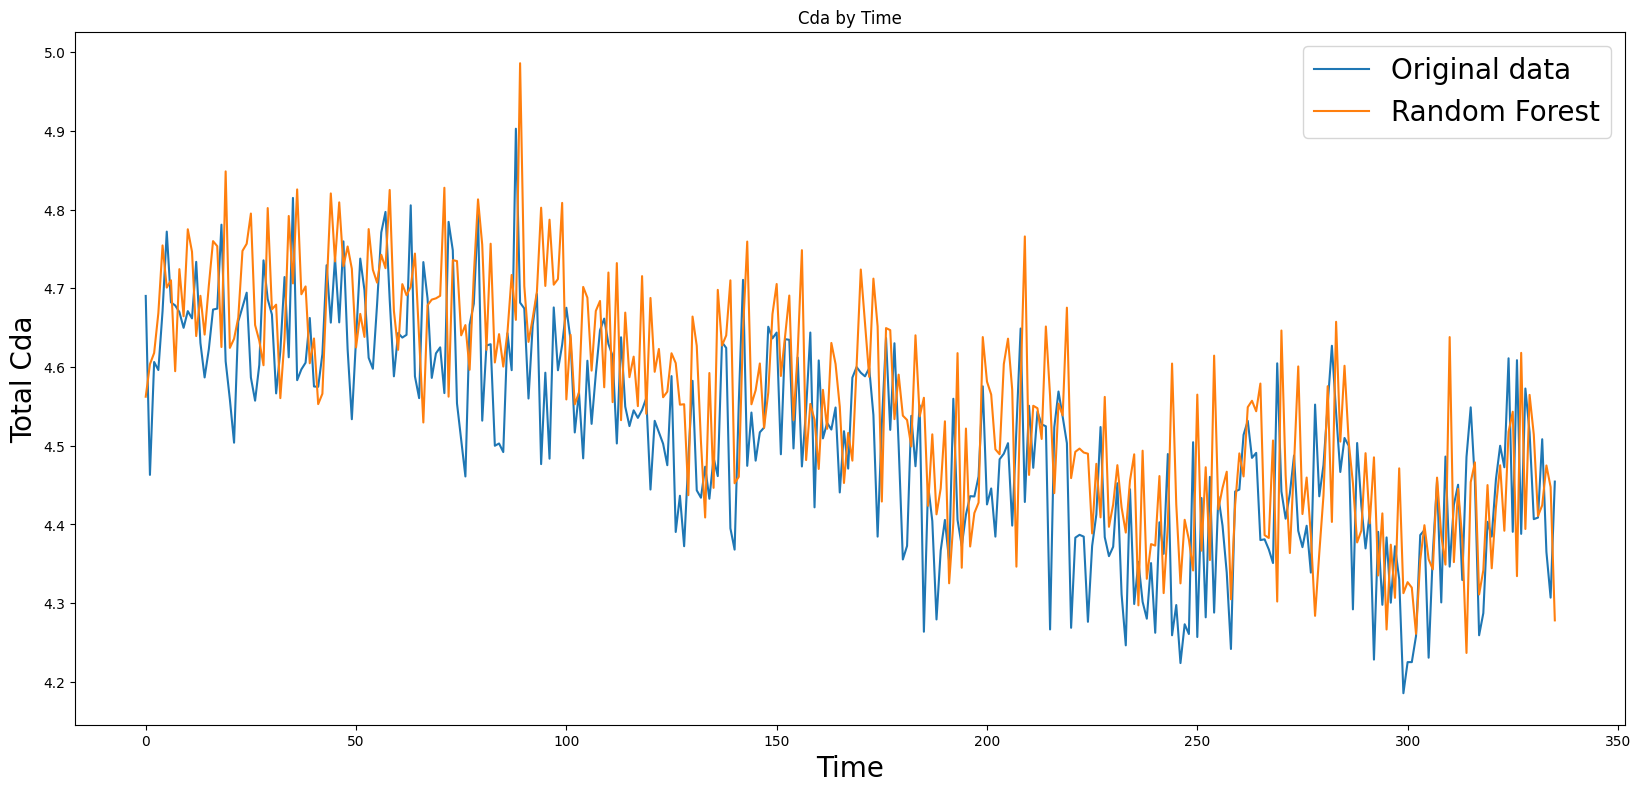

In [61]:
fig = plt.figure(figsize=(20, 9))
plt.plot(test[:, -1], label='Original data')
plt.plot(predictions, label='Random Forest')
plt.legend(fontsize="20")
plt.title('Cda by Time')
plt.ylabel('Total Cda', fontsize="20")
plt.xlabel('Time', fontsize="20")
plt.show()

In [62]:
predictions = list()
size = int(len(list_for_forecast) * 0.66)
train, test = list_for_forecast[0:size], list_for_forecast[size:len(list_for_forecast)]
history = [x for x in train]

for i in range(len(test)):
    testX, testy = test[i, :-1], test[i, -1]
    yhat = decision_tree_forecast(history, testX)
    predictions.append(yhat)
    history.append(test[i])


In [63]:
print("Decision Forest metrics: ")
print("RMSE:", np.sqrt(mean_squared_error(test[:, -1], predictions)))
print("MAPE:", mean_absolute_percentage_error(test[:, -1], predictions))
print("MAE:", mean_absolute_error(test[:, -1], predictions))
print("R2: ", r2_score(test[:, -1], predictions))

Decision Forest metrics: 
RMSE: 0.14035826399253687
MAPE: 0.024500274007485383
MAE: 0.11005639880952381
R2:  -0.09055912213432249


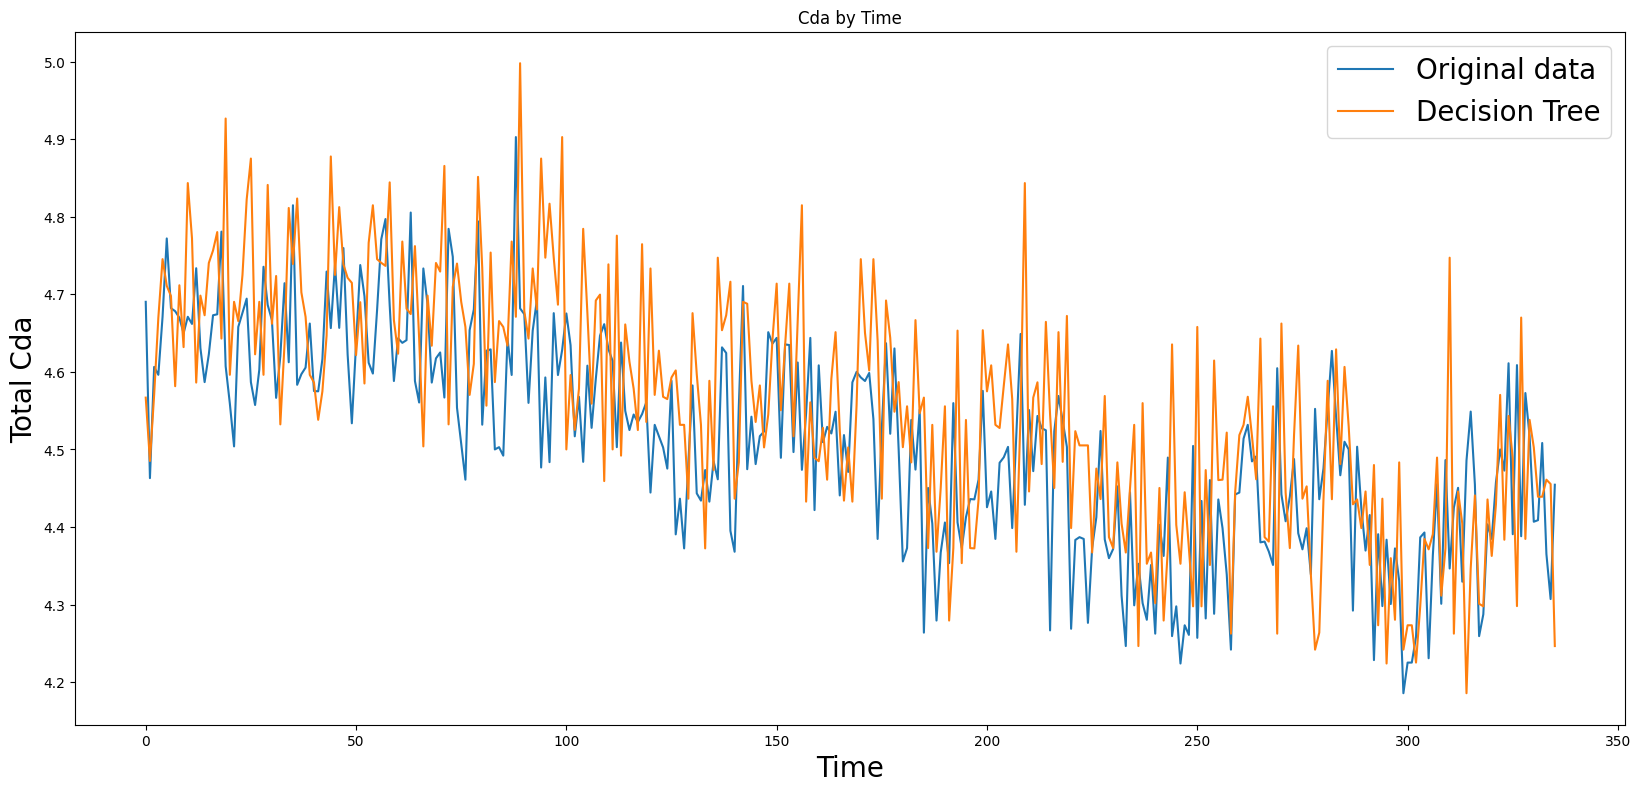

In [64]:
fig = plt.figure(figsize=(20, 9))
plt.plot(test[:, -1], label='Original data')
plt.plot(predictions, label='Decision Tree')
plt.legend(fontsize="20")
plt.title('Cda by Time')
plt.ylabel('Total Cda', fontsize="20")
plt.xlabel('Time', fontsize="20")
plt.show()

## Детекция аномалий с помощью isolated forest

In [65]:
from sklearn.ensemble import IsolationForest

In [66]:
# аналогичным образом загружаем данные о пассажирах
df = pd.read_csv('data/Dutch weekly survey on leftright political orientation 19781996.csv')
# неподходящий формат данных приводим к тому, с которым Pandas может работать
# также устанавливаем индекс и сортируем
df = df.set_index('time').sort_index()
df = pd.DataFrame(df['Cda'])
df

,Cda
time,
1,4.9643
2,4.9923
3,5.0844
4,5.2417
5,5.0712
...,...
984,4.4088
985,4.5083
986,4.3652


In [67]:
model = IsolationForest(contamination=0.004)
model.fit(df[['Cda']])

IsolationForest(contamination=0.004)

In [68]:
df['outliers'] = pd.Series(model.predict(df[['Cda']])).apply(lambda x: 'yes' if (x == -1) else 'no' )

In [69]:
df.query('outliers=="yes"')

,Cda,outliers
time,,
10,5.0772,yes
33,5.0508,yes
67,5.1158,yes
100,5.1724,yes


In [70]:
import plotly.express as px
import nbformat

In [71]:
fig = px.scatter(df.reset_index(), x='time', y='Cda', color='outliers')
fig.update_xaxes(
    rangeslider_visible=True,
)
fig.show()